In [19]:
import tensorflow as tf
import keras as k
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random as r
import numpy as np
import cv2
import imghdr
import os

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from keras import backend
from collections import Counter
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

if tf.test.gpu_device_name():
    print(f'GPU avaliable {tf.test.gpu_device_name()}')
else:
    print('Please install GPU version of TF')
    
print(f'Tensorflow version {tf.version.VERSION}')


GPU avaliable /device:GPU:0
Tensorflow version 2.5.0


## Data processing

In [20]:
CLEAN = False
VAL_SPLIT = 0.2
HEIGHT = 299
WIDTH = 187
BATCH_SIZE = 32
PATH_TRAIN = 'C:/Users/crims/Tensorflow/PublisherIdetification/realpublishers/training/'
PATH_TEST = 'C:/Users/crims/Tensorflow/PublisherIdetification/realpublishers/testing/'

train_generator = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)
test_generator = ImageDataGenerator(rescale=1./255)

print('Training folder:')
train_data = train_generator.flow_from_directory(PATH_TRAIN, target_size=(WIDTH, HEIGHT),
                                                 class_mode = 'categorical', batch_size=BATCH_SIZE, 
                                                 subset = 'training')
print('Validation folder:')
valid_data = train_generator.flow_from_directory(PATH_TRAIN, target_size=(WIDTH, HEIGHT),
                                                 class_mode = 'categorical', batch_size=BATCH_SIZE, 
                                                 subset = 'validation')
print('Test folder:')
test_data = test_generator.flow_from_directory(PATH_TEST, target_size=(WIDTH, HEIGHT), 
                                               class_mode=None, batch_size=1, 
                                               shuffle=False)

class_counter = Counter(train_data.classes)    
class_names = train_data.class_indices
class_num = train_data.num_classes


Training folder:
Found 11119 images belonging to 4 classes.
Validation folder:
Found 2778 images belonging to 4 classes.
Test folder:
Found 20 images belonging to 1 classes.


## Cleaning data (run once per dataset)

In [21]:
if CLEAN == True:
    filenames = train_data.filenames
    n = 0
    while n < train_data.n:
        path = f'{PATH_TRAIN}{filenames[n]}'
        image = cv2.imread(path)
        img_type = imghdr.what(path)
        if img_type != "jpeg":
            print('removing image')
            print(path)
            os.remove(path)
            n += 1
        else:
            n += 1
    print('All done!')    
else:
    print('Skipping clean')

Skipping clean


## Model setup & parameters

In [22]:
LEARN_RATE = 3e-3  #default learning_rate = 1e-3
OPTIMIZER = 'SGD'  #adam, rms, sgd
EPOCHS = 50
BATCH_SIZE = 64
NUM_TRAIN_BATCHES = 100 #BATCH_SIZE * NUM_TRAIN_BATCHES is images processed per epoch
NUM_VAL_BATCHES = NUM_TRAIN_BATCHES * VAL_SPLIT

choices = {'RMS' : tf.keras.optimizers.RMSprop(learning_rate=LEARN_RATE), 
           'Adam': tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
           'SGD' : tf.keras.optimizers.SGD(learning_rate=LEARN_RATE)}   
opt = choices[OPTIMIZER]


In [23]:
base = Xception(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT, 3), pooling='avg')
x = base.output
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(class_num, activation='softmax')(x)
xception = Model(base.input, x)
xception.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=opt)
xception.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 187, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 93, 149, 32)  864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 93, 149, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 93, 149, 32)  0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

## Run model

In [24]:
#Train model
history = xception.fit(train_data, validation_data=valid_data, epochs=EPOCHS, 
                       steps_per_epoch=NUM_TRAIN_BATCHES, validation_steps=NUM_VAL_BATCHES, batch_size=BATCH_SIZE)

xception.save('xception_publisherid')

Epoch 1/50
100/100 [==============================] - 58s 550ms/step - loss: 1.0367 - acc: 0.5759 - val_loss: 0.9072 - val_acc: 0.6234
Epoch 2/50
100/100 [==============================] - 54s 536ms/step - loss: 0.8790 - acc: 0.6438 - val_loss: 0.8529 - val_acc: 0.6297
Epoch 3/50
100/100 [==============================] - 54s 534ms/step - loss: 0.7653 - acc: 0.7197 - val_loss: 0.7453 - val_acc: 0.7094
Epoch 4/50
100/100 [==============================] - 53s 534ms/step - loss: 0.7089 - acc: 0.7419 - val_loss: 0.7044 - val_acc: 0.7094
Epoch 5/50
100/100 [==============================] - 53s 532ms/step - loss: 0.6417 - acc: 0.7541 - val_loss: 0.6969 - val_acc: 0.7172
Epoch 6/50
100/100 [==============================] - 53s 530ms/step - loss: 0.5881 - acc: 0.7625 - val_loss: 0.6569 - val_acc: 0.7297
Epoch 7/50
100/100 [==============================] - 53s 530ms/step - loss: 0.5675 - acc: 0.7763 - val_loss: 0.5944 - val_acc: 0.7406
Epoch 8/50
100/100 [==============================] - 5

C:\Users\crims\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: xception_publisherid\assets


## Model evaluation 

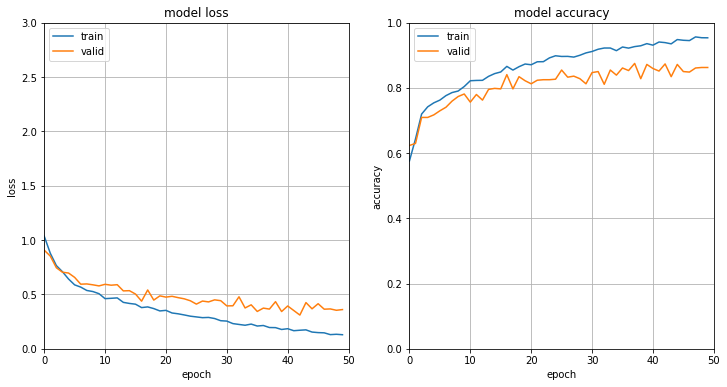

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim([0, 3])
plt.xlabel('epoch')
plt.xlim([0, EPOCHS])
plt.grid()
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.xlabel('epoch')
plt.xlim([0, EPOCHS])
plt.legend(['train', 'valid'], loc='upper left')
plt.grid()
plt.show()

## Predictor

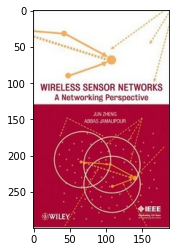

[[0.00974513 0.29311502 0.69490373 0.00223618]]
1st predict Springer Nature with confidence 69.49%
2nd predict Macmillan with confidence 29.312%
Answer is IEEE6537.jpg


In [26]:
n = r.randint(0,19)
filenames = test_data.filenames
path = f'{PATH_TEST}{filenames[n]}'
pic = mpimg.imread(path)
plt.imshow(pic)
plt.show()

img = tf.keras.preprocessing.image.load_img(path, target_size=(WIDTH, HEIGHT))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_processed = tf.keras.applications.xception.preprocess_input(img_batch)

prediction = xception.predict(img_processed)
Top_index = np.argsort(np.max(prediction, axis=0))[-1]
Second_index = np.argsort(np.max(prediction, axis=0))[-2]
print(prediction)
sort = np.sort(max(prediction))
print(f'1st predict {list(class_names)[Top_index]} with confidence {round(sort[len(sort) - 1]*100, 3)}%')
print(f'2nd predict {list(class_names)[Second_index]} with confidence {round(sort[len(sort) - 2] * 100, 3)}%')           
print(f'Answer is {filenames[n][5:]}')
